In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
fluxes_columns = ['y','m','d','ET','R','BF','sm1','sm2','sm3','SWE','Cs','Qs','Ql','Qg','NR','PEText','PETtrc','PETsrc']
forcing_columns = ['P','Tmax','Tmin','W']

In [3]:
fl = './data/flux_snow_40.03125_-105.53125'
fr = './data/Meteorology_Livneh_NAmerExt_15Oct2014_40.03125_-105.53125'

In [4]:
dates = pd.read_pickle('./timecode.pcl')

In [5]:
flux = pd.read_table(fl, sep='\t', names=fluxes_columns) # load fluxes
flux.index = pd.DatetimeIndex(dates)
    
forc = pd.read_table(fr, sep=' ', names=forcing_columns) # load forcing
forc.index = pd.DatetimeIndex(dates)

In [6]:
flux.index.min()

Timestamp('1950-01-01 00:00:00')

In [7]:
flux.index.max()

Timestamp('2013-12-31 00:00:00')

In [6]:
wyears = np.load('./wyears.npy')

In [7]:
cols = ['ablationslope','peakswe','ablationseasonP','gsET','wyP', 'ablationseason']

In [8]:
data = pd.DataFrame(columns=cols, index=wyears)

In [9]:
for wy in wyears:
    strt = str(wy-1)+'-10-01'
    nd = str(wy)+'-09-30'
    
    data.loc[wy,'peakswe'] = flux[strt:nd].SWE.max() # pull max swe
    dopeakswe = flux[strt:nd].SWE.idxmax() # pull day of peak swe
    donosnow = flux[dopeakswe:nd].SWE.idxmin() # pull the day of now snow
    
    ablationseason = (donosnow-dopeakswe).days # compute the ablation season length
    
    data.loc[wy,'gsET'] = flux[dopeakswe:nd].ET.sum() # sum ET over the growing season 
    data.loc[wy,'ablationslope'] = data.loc[wy,'peakswe']/ablationseason # compute the average daily melt rate and store it
    data.loc[wy,'ablationseason'] = ablationseason # save the ablation season length
    data.loc[wy,'ablationseasonP'] = forc[dopeakswe:donosnow].P.sum()/ablationseason
    
    data.loc[wy,'wyP'] = forc[strt:nd].P.sum() # sum and store water year P
    

In [10]:
data.head()

,ablationslope,peakswe,ablationseasonP,gsET,wyP,ablationseason
1951,5.969521,334.2932,2.599286,481.6596,859.62,56
1952,7.081557,297.4254,3.777143,518.9008,839.14,42
1953,3.81896,160.3963,2.467857,495.8938,635.66,42
1954,2.839413,65.3065,0.2395652,408.0278,510.92,23
1955,3.179743,155.8074,0.8910204,494.9525,635.46,49


In [11]:
data['gsET_P']= data.gsET/data.wyP
data['flux'] = data.ablationslope+data.ablationseasonP

In [12]:
data.head()

,ablationslope,peakswe,ablationseasonP,gsET,wyP,ablationseason,gsET_P,flux
1951,5.969521,334.2932,2.599286,481.6596,859.62,56,0.5603169,8.568807
1952,7.081557,297.4254,3.777143,518.9008,839.14,42,0.6183721,10.8587
1953,3.81896,160.3963,2.467857,495.8938,635.66,42,0.7801244,6.286817
1954,2.839413,65.3065,0.2395652,408.0278,510.92,23,0.7986138,3.078978
1955,3.179743,155.8074,0.8910204,494.9525,635.46,49,0.7788885,4.070763


In [25]:
data.to_pickle('./data/AFX_cell.df')

In [13]:
data.loc[data.gsET_P>1,:] = np.NaN

In [14]:
data.gsET_P.max()

0.88878590099474142

                            OLS Regression Results                            
Dep. Variable:                 gsET_P   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     70.80
Date:                Tue, 03 Feb 2015   Prob (F-statistic):           9.65e-12
Time:                        12:28:47   Log-Likelihood:                 74.184
No. Observations:                  62   AIC:                            -144.4
Df Residuals:                      60   BIC:                            -140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9062      0.027     33.840      0.0

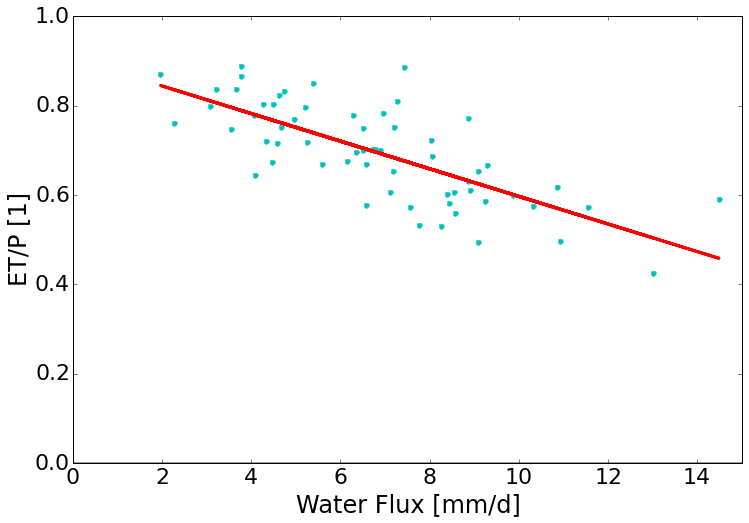

In [22]:
data2 = data.dropna(subset=['flux','gsET_P']).astype(float)
X = data2.flux
y = data2.gsET_P
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()

titlefont = 28
axfont = 22
labelfont = 24
annotatefont = 20


EQ = 'y = '+str(round(results.params[1],3))+'x + '+str(round(results.params[0],3))
params = 'r$^2$='+str(round(results.rsquared,3))+', p='+str(round(results.f_pvalue,3))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(X.flux,y,'.c',markersize=10);
ax.plot(X.flux,results.fittedvalues,'-r', lw=3);
ax.set_xlim([0,15])
ax.set_ylim([0,1])
#ax.set_title('1 Day Soil Moisture Lag', fontsize = titlefont);
ax.set_xlabel('Water Flux [mm/d]', fontsize= labelfont);
ax.set_ylabel('ET/P [1]', fontsize=labelfont);
plt.setp(ax.get_xticklabels(),fontsize=axfont)
plt.setp(ax.get_yticklabels(),fontsize=axfont)
ax.axhline(0,c='0.5', lw=1.5);
ax.axvline(0,c='0.5', lw=1.5);
#ax.text(7,10,EQ, fontsize = annotatefont)
#ax.text(7,9,params, fontsize = annotatefont)
#plt.savefig('/Users/barnhatb/Dropbox/CUB/05_Spring_2015/WSC PI meeting/figures/short_term_SM_water_flx.pdf',bbox_inches='tight',transparent=True)

print results.summary()

In [27]:
results.rsquared_adj

0.53365413796419037

In [24]:
np.var(y)

0.01166040313675515

In [23]:
results.save('./models/niwot_vic_gsET_PvsFlux.mod')

In [81]:
results.fittedvalues

array([0.64106689535859807, 0.57020292157142338, 0.71168631878835364,
       0.81095741612062344, 0.78026522616174609, 0.75303195183775218,
       0.50382140085806171, 0.68303687034607552, 0.64682286164967828,
       0.74506687522512982, 0.66637502550893379, 0.67636120279443301,
       0.79653113409128384, 0.75941323157487939, 0.62479938657821887,
       0.7798589432126084, 0.69809264468592236, 0.70955888733301786,
       0.62035067213346462, 0.70307844461905555, 0.79324534617778641,
       0.54858155749532533, 0.7026773017195741, 0.68605468031152639,
       0.80651237111769047, 0.8452616462906154, 0.71580302784140382,
       0.63098142199373086, 0.62504300955950198, 0.73919960381224559,
       0.83599654325848483, 0.6720916571460035, 0.45803465386000569,
       0.76335170648820716, 0.77217456763022629, 0.61904748781957109,
       0.70495852136196602, 0.77431900177558288, 0.70457884428147921,
       0.76416445519918097, 0.65757378300335967, 0.64147518432265949,
       0.681170273191209

In [72]:
X

array([[1.0, 8.5688071428571426],
       [1.0, 10.858699999999999],
       [1.0, 6.2868166666666667],
       [1.0, 3.0789782608695653],
       [1.0, 4.0707632653061223],
       [1.0, 4.9507771428571434],
       [1.0, 13.003747222222222],
       [1.0, 7.2125926829268288],
       [1.0, 8.3828093023255814],
       [1.0, 5.2081600000000003],
       [1.0, 7.7510022222222226],
       [1.0, 7.4283096774193549],
       [1.0, 3.5451480000000002],
       [1.0, 4.7445729729729731],
       [1.0, 9.0944741379310337],
       [1.0, 4.0838918604651155],
       [1.0, 6.726081578947368],
       [1.0, 6.3555623188405796],
       [1.0, 9.238229545454546],
       [1.0, 6.5649708333333336],
       [1.0, 3.6513246913580248],
       [1.0, 11.557371052631579],
       [1.0, 6.5779333333333341],
       [1.0, 7.1150754098360665],
       [1.0, 3.2226150943396226],
       [1.0, 1.9704740740740738],
       [1.0, 6.1537896551724138],
       [1.0, 8.8947083333333339],
       [1.0, 9.0866017241379318],
       [1.0, 5.3

In [34]:
td = donosnow-dopeakswe

In [35]:
td.days

56

In [27]:
donosnow

Timestamp('1951-06-17 00:00:00')

In [23]:
dopeakswe

Timestamp('1951-04-22 00:00:00')